In [70]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,LassoCV,RidgeCV,ElasticNetCV,Lasso
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
import re

In [3]:
## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False

In [4]:
#读取数据
path1='./datas/household_power_consumption_1000.txt'
data=pd.read_csv(path1,sep=';')
print(data.head(10))
#查看数据信息
print(data.info())
print(data.describe())

         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   
5  16/12/2006  17:29:00                3.520                  0.522   235.02   
6  16/12/2006  17:30:00                3.702                  0.520   235.09   
7  16/12/2006  17:31:00                3.700                  0.520   235.22   
8  16/12/2006  17:32:00                3.668                  0.510   233.99   
9  16/12/2006  17:33:00                3.662                  0.510   233.86   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1

In [5]:
#异常数据的处理
new_data=data.replace({'?':np.NAN})
data=new_data.dropna(how='any',axis=0)

In [6]:
#将时间处理成数值型数据
def time_transfer(t):
    t=" ".join([t['Date'],t['Time']])
    t=time.strptime(t,'%d/%m/%Y %H:%M:%S')
    return pd.Series([t.tm_year,t.tm_mon,t.tm_mday,t.tm_hour,t.tm_min,t.tm_sec])
          
col=data.columns
X=data[col[:2]]
X=X.apply(time_transfer,axis=1)
print(X.head(3))
Y=data[col[4]]

      0   1   2   3   4  5
0  2006  12  16  17  24  0
1  2006  12  16  17  25  0
2  2006  12  16  17  26  0


In [7]:
#将特征向量标准化,并将数据进行切分为训练集和测试集
ss=StandardScaler()
#X=ss.fit_transform(X)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=1)
X_train=ss.fit_transform(X_train)
X_test=ss.transform(X_test)

In [8]:
models=[Pipeline([('ss',StandardScaler()),('Poly',PolynomialFeatures()),('Linear',LinearRegression())]),\
       Pipeline([('ss',StandardScaler()),('Poly',PolynomialFeatures()),('Linear',LassoCV(alphas=[0.1,0.2]))]),\
       Pipeline([('ss',StandardScaler()),('Poly',PolynomialFeatures()),('Linear',RidgeCV(alphas=[0.1,0.2]))]),\
           Pipeline([('ss',StandardScaler()),('Poly',PolynomialFeatures()),('Linear',ElasticNetCV(alphas=[0.1,0.2],l1_ratio=[.2,.4]))])]

In [9]:
#models[1].get_params().keys()

In [10]:
#不要设置LassoCV的alphas,因为alphas的选择不是在GridsearchCV中通过交叉验证获取的
parameters={'Poly__degree':[1,2],\
           'Linear__fit_intercept':[True,False],\
           'Poly__interaction_only':[True,False],\
            'Poly__include_bias':[True,False]
           }

In [11]:
model=GridSearchCV(models[0],param_grid=parameters,cv=5)
model.fit(X_train,Y_train)
#pd.DataFrame(model.cv_results_)
model.best_estimator_

Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('Linear', LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False))])

In [12]:
#print(pd.DataFrame(model.cv_results_ ))

{'Linear__fit_intercept': False, 'Poly__degree': 2, 'Poly__include_bias': True, 'Poly__interaction_only': False}


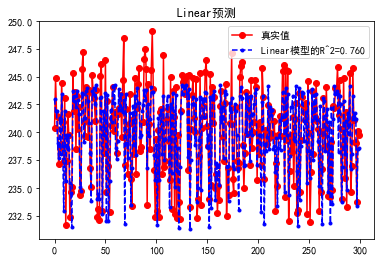

{'Linear__fit_intercept': False, 'Poly__degree': 2, 'Poly__include_bias': False, 'Poly__interaction_only': False}


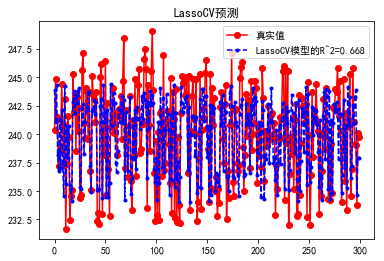

{'Linear__fit_intercept': False, 'Poly__degree': 2, 'Poly__include_bias': True, 'Poly__interaction_only': False}


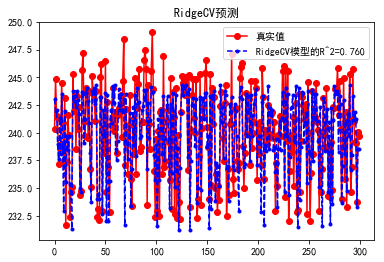

{'Linear__fit_intercept': True, 'Poly__degree': 2, 'Poly__include_bias': True, 'Poly__interaction_only': False}


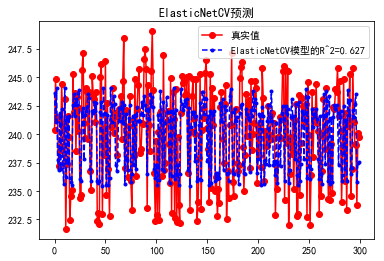

In [121]:
#通过GridsearchCV对参数网格进行比较以及筛选效果最优的参数,但保持模型的时候，将最优的参数设置到模型中，重新训练后再保持，
#而不能直接保持GridSearchCV返回的最优模型
titles = ['Linear','LassoCV', 'RidgeCV','ElasticNetCV']
k=0
t=range(len(X_test))
for m in models:
    model=GridSearchCV(m,param_grid=parameters,cv=5)
    model.fit(X_train,Y_train)
    Y_pridict=model.predict(X_test)#用最优参数的模型进行预测
    #m.get_params()['Linear']=model.best_estimator_
    #print(model.best_estimator_.get_params()['Linear'])
    print(model.best_params_)
    plt.figure()
    plt.plot(t,Y_test,'ro-',label='真实值')
    plt.plot(t,Y_pridict,'b.--',label='%s模型的R^2=%.3f' %(titles[k],model.best_score_))
    plt.legend()
    plt.title('%s预测' %(titles[k]))
    plt.show()
    k+=1
#     params={}
#     for k,v in model.best_params_.items():
#         k1=k.partition('__')[2]
#         params[k1]=v
#     m.set_params(**model.best_params_)
#     print(m.get_params())
    
    #print(model )
    

In [122]:
dd.set_params??

In [83]:
'fit_intercept' in dd.get_params(deep=True)

True

In [85]:
'fit_intercept'.partition('__')

('fit_intercept', '', '')

In [97]:
def set_params(dd,**params):
        """Set the parameters of this estimator.

        The method works on simple estimators as well as on nested objects
        (such as pipelines). The latter have parameters of the form
        ``<component>__<parameter>`` so that it's possible to update each
        component of a nested object.

        Returns
        -------
        self
        """
        print(params)
        for key, value in params.items():
            key, delim, sub_key = key.partition('__')
            print(key)
            if key not in dd.get_params().keys():
                raise ValueError('Invalid parameter %s for estimator %s. '
                                 'Check the list of available parameters '
                                 'with `estimator.get_params().keys()`.')


In [100]:
set_params(dd,**{'fit_intercept__': False})

{'fit_intercept__': False}
fit_intercept
